In [1]:
import numpy as np
import scipy as sp
from scipy import optimize,special,integrate,stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import copy

from lanczos_bin import *

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# $x/|x|$

In [3]:
lam = np.hstack([-model_problem_spectrum(100,.9,1e2)[::-1],model_problem_spectrum(300,.8,1e3)])
A_mat = lam

n = len(A_mat)
b_vec = np.ones(n,dtype=np.double)
b_vec /= np.linalg.norm(b_vec)

f = lambda x: x/abs(x)#(A*x**2+B*x+C)/(a*x**2+b*x+c)
fAb = f(A_mat)*b_vec
    
K = 100
Q,(a_,b_) = exact_lanczos(A_mat,b_vec,K,reorth=True)

In [4]:
error_opt = np.full(K,np.nan)
error_FA = np.full(K,np.nan)
error_OR = np.full(K,np.nan)
error_HA = np.full(K,np.nan)

error_opt2 = np.full(K,np.nan)
error_FA2 = np.full(K,np.nan)
error_OR2 = np.full(K,np.nan)
error_HA2 = np.full(K,np.nan)

for i in range(1,K):
    
    opt = Q[:,:i]@np.linalg.solve(Q[:,:i].T@np.diag(A_mat**2)@Q[:,:i],Q[:,:i].T@(A_mat**2*fAb))
    error_opt[i] = np.linalg.norm(A_mat*(fAb - opt))

    opt2 = Q[:,:i]@(Q[:,:i].T@fAb)
    error_opt2[i] = np.linalg.norm(fAb - opt2)

    T = np.diag(a_[:i]) + np.diag(b_[:i-1],1) + np.diag(b_[:i-1],-1)
    theta,S = sp.linalg.eigh(T)
    
    lank_FA = Q[:,:i]@(S@(f(theta)*S[0]))
    error_FA[i] = np.linalg.norm(A_mat*(fAb - lank_FA))
    error_FA2[i] = np.linalg.norm(fAb - lank_FA)
   
    TT_ = T@T
    TT_[-1,-1] += b_[i-1]**2
    theta,S = sp.linalg.eigh(TT_)
    
    lank_OR = Q[:,:i]@(S@((1/np.sqrt(theta))*(S.T@T[0])))
    error_OR[i] = np.linalg.norm(A_mat*(fAb - lank_OR))
    error_OR2[i] = np.linalg.norm(fAb - lank_OR)
   
    T_ = np.copy(T)

    ek1 = np.zeros(i)
    ek1[-1] = 1
    e0 = np.zeros(i)
    e0[0] = 1
    
    z = b_[i-1]**2*np.linalg.solve(T,ek1)
    T_[:,-1] += z
    theta,S = sp.linalg.eig(T_)

    hark = Q[:,:i]@(S@(f(np.real(theta))*np.linalg.solve(S,e0)))
    error_HA[i] = np.linalg.norm(A_mat*(fAb - hark))
    error_HA2[i] = np.linalg.norm(fAb - hark)
    

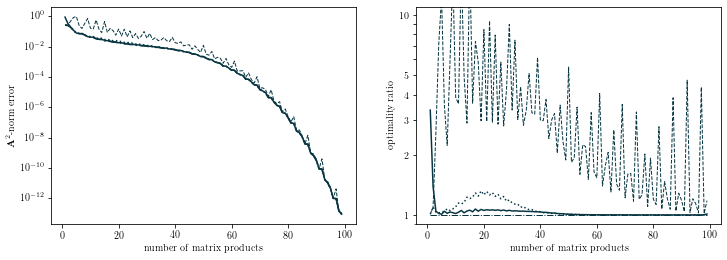

In [5]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=False)
fig.subplots_adjust(wspace=.2,hspace=.05)

axs[0].plot(error_opt/np.linalg.norm(A_mat*b_vec),color='#073642',ls='-.',label='opt')
axs[0].plot(error_FA/np.linalg.norm(A_mat*b_vec),color='#073642',ls='--',lw=1,label='lan-FA')
axs[0].plot(error_OR/np.linalg.norm(A_mat*b_vec),color='#073642',label='lan-OR')
axs[0].plot(error_HA/np.linalg.norm(A_mat*b_vec),color='#073642',ls=':',label='harmonic')

axs[0].set_yscale('log')

#axs[0].set_ylim(1e-5,1e1)

axs[1].plot(error_opt/error_opt,color='#073642',ls='-.',lw=1,label='opt')
axs[1].plot(error_FA/error_opt,color='#073642',ls='--',lw=1,label='lan-FA')
axs[1].plot(error_OR/error_opt,color='#073642',label='lan-OR')
axs[1].plot(error_HA/error_opt,color='#073642',ls=':',label='harmonic')

#plt.yscale('log')

axs[1].set_ylim(.9,11)
axs[1].set_yscale('log')
axs[1].set_yticks(np.arange(1,11))
axs[1].set_yticklabels([1,2,3,4,5,'','','','',10])

axs[0].set_xlabel('number of matrix products')
axs[1].set_xlabel('number of matrix products')

axs[0].set_ylabel('$\mathbf{A}^2$-norm error')
axs[1].set_ylabel('optimality ratio')


plt.savefig('imgs/sign.pdf',bbox_inches='tight')

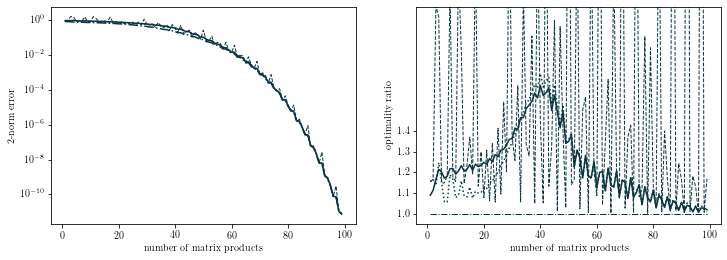

In [6]:
fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=False)
fig.subplots_adjust(wspace=.2,hspace=.05)

axs[0].plot(error_opt2/np.linalg.norm(b_vec),color='#073642',ls='-.',label='opt')
axs[0].plot(error_FA2/np.linalg.norm(b_vec),color='#073642',ls='--',lw=1,label='lan-FA')
axs[0].plot(error_OR2/np.linalg.norm(b_vec),color='#073642',label='lan-OR')
axs[0].plot(error_HA2/np.linalg.norm(b_vec),color='#073642',ls=':',label='harmonic')

axs[0].set_yscale('log')

#axs[0].set_ylim(1e-5,1e1)

axs[1].plot(error_opt2/error_opt2,color='#073642',ls='-.',lw=1,label='opt')
axs[1].plot(error_FA2/error_opt2,color='#073642',ls='--',lw=1,label='lan-FA')
axs[1].plot(error_OR2/error_opt2,color='#073642',label='lan-OR')
axs[1].plot(error_HA2/error_opt2,color='#073642',ls=':',label='harmonic')

#plt.yscale('log')

#axs[1].set_yscale('log')
axs[1].set_ylim(.95,2)
axs[1].set_yticks([1,1.1,1.2,1.3,1.4])

axs[0].set_xlabel('number of matrix products')
axs[1].set_xlabel('number of matrix products')

axs[0].set_ylabel('2-norm error')
axs[1].set_ylabel('optimality ratio')


plt.savefig('imgs/sign2.pdf',bbox_inches='tight')